In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
recalc_means = False #recalculate the groupwise mean stats. Set to False to load from file
demo_mode = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotfuncs as plf

### the hdf5 file 'trial_db.hdf5' holds a table of every trial performed on all flies. This analysis will only focus on one cohort.  The stimulus set for this cohort included forward,backward,upward and downward translational motion and yaw to the left and right.

In [3]:
import h5py
trial_db = h5py.File('../02_imaging_post_processing/trial_db.hdf5','a')

In [4]:
trial_types = set(trial_db['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list)
fly_set_39E01 = set(gd.GMR39E01_list)

In [5]:
#mask out the data so only the trial types in test_set will be included we dont want to look
#at stripe fixation, or flight initataion or termination events
trial_mask = np.zeros(np.shape(trial_db['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    trial_mask = trial_mask | (np.array(trial_db['trial_names']) == trial_name)

#now mask out the data to only include the flys in gd.GRM22H05_list
fly_mask = np.zeros_like(trial_mask,dtype = bool)
for fly in fly_set:
    fly_mask = fly_mask | (np.array(trial_db['fly_numbers']) == fly)

#now mask out the data to only include the flys in gd.GRM22H05_list
fly_mask_39E01 = np.zeros_like(trial_mask,dtype = bool)
for fly in fly_set_39E01:
    fly_mask_39E01 = fly_mask_39E01 | (np.array(trial_db['fly_numbers']) == fly)

#update the mask    
mask = trial_mask & fly_mask
mask_39E01 = trial_mask & fly_mask_39E01

# Create a selection array to include only epochs with flight for for the entire trial - i.e. the number of samples
# with a wing-beat frequency > 100  was equal to the number of samples in the trial
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=np.shape(trial_db['wb_frequency'])[1]
mask = mask & flt_selection
mask_39E01 = mask_39E01 & flt_selection

### the stimulus protocol for this cohort was 3 s of motion flanked by a 10s static presentation. All trials were interlieved by 5s of closed-loop stripe fixation.

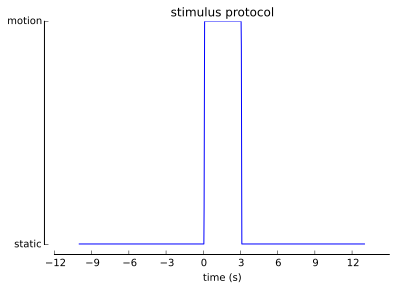

In [6]:
#plb.figure(figsize = (8,3))
sig = trial_db['StimCond'][mask,:][0]
plb.plot(gd.get_xio('yaw_right'),sig)
plb.gca().set_ybound(0,np.max(sig))
plf.pull_ax_spines()
plb.gca().set_xticks(np.arange(-12,15,3));plb.gca().set_xlabel('time (s)');plb.gca().set_title('stimulus protocol')
plb.gca().set_yticks([0,np.max(sig)])
plb.gca().set_yticklabels(['static','motion']);

### The static patern exposed a drift in the left-right wingstroke amplitude that reached steady-state around 5s

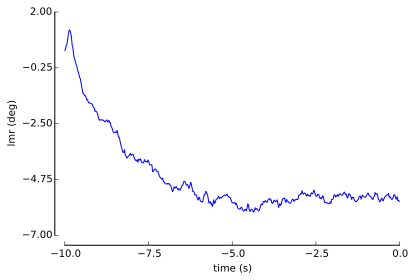

In [7]:
#On swiching from closed-loop to open-loop the fly drifts into a leftward turn 
#that reaches steady-state at around 4 sec. 
xi = gd.get_xio('yaw_right')
prestim_lmr = np.mean(np.array(trial_db['Ph2'][mask,:])[:,xi<0],axis = 0)
plb.plot(xi[xi<0],gd.signal_plot_info['Ph2']['transform'](prestim_lmr))
plf.pull_ax_spines()
plb.gca().set_ylabel('lmr (deg)')
plb.gca().set_xlabel('time (s)')

In [8]:
demo_mode = False
if not(demo_mode):
    import os
    os.remove('open_loop_trial_db.hdf5')
    os.remove('open_loop_trial_db_39E01.hdf5')
    mtd = h5py.File('open_loop_trial_db.hdf5','a')
    mtd_39E01 = h5py.File('open_loop_trial_db_39E01.hdf5','a')
else:
    mtd = h5py.File('open_loop_trial_db.hdf5','r')

### subtract the mean and normalize by the variance during the three seconds prior to stimulus onset

In [9]:
def get_norm_term(signal,mask = mask,xi_range = (-3,0),xio_trial_name = 'yaw_left'):
    """get the norm and mean value over the samples in the time range xi_range 
    for the data in the matrix 'signals' with rows selected by mask. trial_name is
    used to determine the mapping from samples to times in xi_range"""
    data_selection = trial_db[signal][mask,:]
    xi = gd.get_xio(trial_name)
    baseline_mask = (xi>xi_range[0]) & (xi<[xi_range[1]]) 
    mean_val = np.nanmean(data_selection[:,baseline_mask])#,axis = 1)[:,np.newaxis]
    subtracted_selection = data_selection-mean_val
    return np.nanstd(subtracted_selection[:,baseline_mask]),mean_val

In [10]:
if not(demo_mode):
    #create dictionary to store the normalization values
    signal_norms = dict()
    signal_means = dict()
    #the signal norms will be computed for the 'matrix' like signals, init with a blank selection mask
    [signal_norms.update({signame:np.zeros_like(mask)}) for signame,dset in trial_db.items() if (np.ndim(dset)>1)];
    [signal_means.update({signame:np.zeros_like(mask)}) for signame,dset in trial_db.items() if (np.ndim(dset)>1)];
    #create a vector of norm values for each trial
    for fly in fly_set.union(fly_set_39E01): #loop over all the flies in fly_set
        fly_selection_mask = np.array(trial_db['fly_numbers']) == fly #create a selection mask for the fly
        for nor,mea in zip(signal_norms.items(),signal_means.items()): #loop over all the signals
            sig_key = nor[0]
            norm_array = nor[1]
            mean_array = mea[1]
            norm_val,mean_val = get_norm_term(sig_key,mask = fly_selection_mask,xio_trial_name = 'yaw_left')
            if ~np.isfinite(norm_val):
                norm_val = 0
            if ~np.isfinite(mean_val):
                mean_val = 0
            signal_norms[sig_key] = norm_array + (fly_selection_mask*norm_val) #add in the normalization values
            signal_means[sig_key] = mean_array + (fly_selection_mask*mean_val)

In [11]:
if not(demo_mode):
    #dataset to hold the normalized data
    mtd.create_group('normed_signals')
    #also save a copy of the untransformed data 
    mtd.create_group('selected_signals')
    #now for the second cohort
    mtd_39E01.create_group('normed_signals')
    mtd_39E01.create_group('selected_signals')

In [12]:
if not(demo_mode):
    #create mean subtracted and normalized datasets for each of the 'matrix' like signals
    for k in signal_norms.keys():
        ssig = trial_db[k][mask,:]
        flb.update_dset(mtd['selected_signals'],k,ssig)
        xi = gd.get_xio('yaw_left')
        baseline_idx = xi<0
        nsig = (ssig - signal_means[k][mask][:,np.newaxis])/signal_norms[k][mask][:,np.newaxis]
        flb.update_dset(mtd['normed_signals'],k,nsig)
   
        ssig = trial_db[k][mask_39E01,:]
        flb.update_dset(mtd_39E01['selected_signals'],k,ssig)
        xi = gd.get_xio('yaw_left')
        baseline_idx = xi<0
        nsig = (ssig - signal_means[k][mask_39E01][:,np.newaxis])/signal_norms[k][mask_39E01][:,np.newaxis]
        flb.update_dset(mtd_39E01['normed_signals'],k,nsig)

In [16]:
if not(demo_mode):
    #now apply the masked selection to the trial description vectors and store
    for key,dset in trial_db.items():
        if (np.ndim(dset)<2):
            if not(key == u'signal_units'):
                flb.update_dset(mtd['selected_signals'],key,dset[mask])
                flb.update_dset(mtd_39E01['selected_signals'],key,dset[mask_39E01])

In [17]:
#def get_trial_mtrx(signal,trial):
#    """pull out a matrix for a single trial type from the normalized datasets"""
#    selection = np.array(mtd['selcted_signals']['trial_names']) == trial
#    return mtd['normed_signals'][signal][selection,:]

### Sort all the tables acording to the magnitude of the left-right response

In [18]:
if not(demo_mode):
    #use the left-right amplitude (Ph2) as the sort index
    stim_ep = (0,3)
    sig = np.array(mtd['normed_signals']['Ph2'])
    sort_idx = np.argsort(np.mean(sig[:,(xi>stim_ep[0]) & (xi<stim_ep[1])],axis = 1))[::-1] #reverse ordered
    flb.update_dset(mtd,'sort_idx',sort_idx)
    
    sig = np.array(mtd_39E01['normed_signals']['Ph2'])
    sort_idx = np.argsort(np.mean(sig[:,(xi>stim_ep[0]) & (xi<stim_ep[1])],axis = 1))[::-1] #reverse ordered
    flb.update_dset(mtd_39E01,'sort_idx',sort_idx)

In [19]:
if not(demo_mode):
    #resort all of the columns in the dataset by sort idx - will make life easier in the future
    for key,value in mtd['normed_signals'].items():
        mtd['normed_signals'][key][:] = np.array(mtd['normed_signals'][key])[mtd['sort_idx']]
        
    for key,value in mtd_39E01['normed_signals'].items():
        mtd_39E01['normed_signals'][key][:] = np.array(mtd_39E01['normed_signals'][key])[mtd_39E01['sort_idx']]

In [20]:
if not(demo_mode):
    #apply the same sorting to the selection vectors
    for key,value in mtd['selected_signals'].items():
        mtd['selected_signals'][key][:] = np.array(mtd['selected_signals'][key])[mtd['sort_idx']]
    for key,value in mtd_39E01['selected_signals'].items():
        mtd_39E01['selected_signals'][key][:] = np.array(mtd_39E01['selected_signals'][key])[mtd_39E01['sort_idx']]

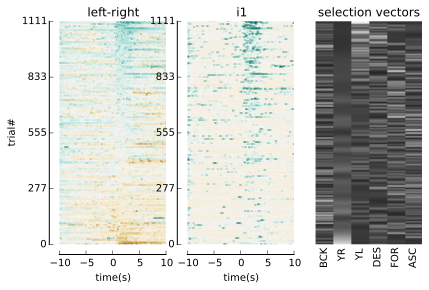

In [32]:
#Check to see if trials are sorted correctly and examine
# how the trial types are co-sorted by lmr response
xi = gd.get_xio('yaw_right')
plb.figure(figsize = (6.5,4))

plb.subplot(1,3,1)
shp = np.shape(mtd['normed_signals']['Ph2'])
plb.imshow(mtd['normed_signals']['Ph2'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_ylabel('trial#')
plb.gca().set_title('left-right')

plb.subplot(1,3,2)
shp = np.shape(mtd['normed_signals']['i1'])
plb.imshow(mtd['normed_signals']['i1'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_title('i1')

trial_list = list(set(mtd['selected_signals']['trial_names']))

def smooth_inter_fun(r):
    from scipy import interpolate
    s = interpolate.UnivariateSpline(np.arange(len(r)), r)
    s.set_smoothing_factor(120)
    xnew = np.arange(0, len(r)-1, .1)
    return s(xnew)

trial_mtrx = [smooth_inter_fun((np.array(mtd['selected_signals']['trial_names']) == sig)) for sig in trial_list]
plb.subplot(1,3,3)
plb.imshow(np.array(trial_mtrx).T[::-1],aspect = 'auto',cmap = plb.cm.gray)
plf.kill_spines()
trial_list = [gd.trial_to_label[tr] for tr in trial_list]
trial_list = [None] + trial_list
plb.gca().set_xticklabels(trial_list,rotation = 90)
[x.set_visible(True) for x in plb.gca().get_xticklabels()]

plb.gca().get_xaxis().majorTicks[1].label1.set_horizontalalignment('center')
plb.gca().set_title('selection vectors')

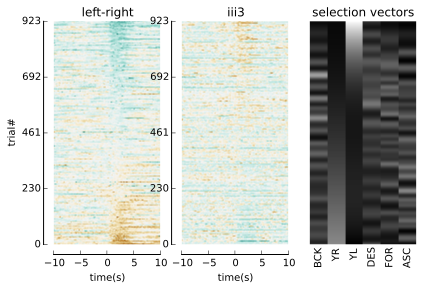

In [36]:
#Check to see if trials are sorted correctly and examine
# how the trial types are co-sorted by lmr response
xi = gd.get_xio('yaw_right')
plb.figure(figsize = (6.5,4))

plb.subplot(1,3,1)
shp = np.shape(mtd_39E01['normed_signals']['Ph2'])

plb.imshow(mtd_39E01['normed_signals']['Ph2'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_ylabel('trial#')
plb.gca().set_title('left-right')

plb.subplot(1,3,2)
shp = np.shape(mtd_39E01['normed_signals']['iii3'])
plb.imshow(mtd_39E01['normed_signals']['iii3'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_title('iii3')

trial_list = list(set(mtd['selected_signals']['trial_names']))

def smooth_inter_fun(r):
    from scipy import interpolate
    s = interpolate.UnivariateSpline(np.arange(len(r)), r)
    s.set_smoothing_factor(120)
    xnew = np.arange(0, len(r)-1, .1)
    return s(xnew)

trial_mtrx = [smooth_inter_fun((np.array(mtd_39E01['selected_signals']['trial_names']) == sig)) for sig in trial_list]
plb.subplot(1,3,3)
plb.imshow(np.array(trial_mtrx).T[::-1],aspect = 'auto',cmap = plb.cm.gray)
plf.kill_spines()
trial_list = [gd.trial_to_label[tr] for tr in trial_list]
trial_list = [None] + trial_list
plb.gca().set_xticklabels(trial_list,rotation = 90)
[x.set_visible(True) for x in plb.gca().get_xticklabels()]

plb.gca().get_xaxis().majorTicks[1].label1.set_horizontalalignment('center')
plb.gca().set_title('selection vectors')

In [37]:
if not(demo_mode):
    trial_db.close()
    mtd.flush()
    mtd.close()
    mtd_39E01.flush()
    mtd_39E01.close()